# Coursework: The Art Gallery Protection Problem

## Import relevant libraries

In [1]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv


## Set up  

Depending on the instance you are trying to solve, set the following parameters


In [ ]:
# Windows and Mac:  set the path to the location of the instance you want to test, examples shown below


# myinst = ""  # empty string defaults to instance with no walls
myinst = "./artGalleryTestInstances/rooms.csv"
# myinst = "./artGalleryTestInstances/pacman.csv"

instance_file = myinst  # the name of the file specifying the layout - use "" to represent an empty grid to an empty grid

#  COLAB: upload the instance to colab and
# instance_file = "./name_of_instance_file"

# all the instances provided have the same size
instance_size  = 100 # number of cells per dimension, i.e total number of cells in the grid is instance_size*instance_size

num_cells = instance_size * instance_size # total number of cells in the grid


In [3]:

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls

walls = np.zeros(instance_size * instance_size)

with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for line in csv_reader:
        column = int(line[0])
        row = int(line[1])
        oneD_index = (row * instance_size) + column
        walls[oneD_index] = 1


In [4]:

# set the correct binary depending on your machine/setup - you need to choose one of the options below and set the path correctly

# for MacOS
#path_binary = "/Users/emma/Downloads/ealain/build/bit_cam_napier_mac_24"
#path_binary_vis = "/path-to-binary/bit_cam_napier_visualisation_mac"


# On Windows: change the following to the location of the binary on your system
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"


# on Colab: YOU MUST UPLOAD THE BINARIES TO COLAB
#!chmod 755 -R ./bit_cam_napier_colab
#!chmod 755 -R ./bit_cam_napier_visualisation_colab


# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)
        


## Random Search Heuristic
You *must* use this function to obtain a baseline to compare your results to.

You need to set **n_guesses** to be equal to the total number of evaluations used in your EA. For example, if you use EASimple with a population size of 50 and run for 100 generations then the total number of evaluations is (50x100)


In [5]:
# random search

def RandomSearch(n, myinst, max_cameras):
    best = np.inf

    for i in range(n):
        # select a random numner of cameras 
        nb_cam = random.randint(1, max_cameras)
        sol = np.zeros(100*100)

        # select which positions should have cameras
        indexes = random.sample(range(0, 10000), nb_cam)
        for j in indexes:
            sol[j] = 1

        fitness = objective_function(sol, instance_size, nb_cameras=len(indexes), instance_file=myinst)

        if fitness < best:
            best = fitness
            best_sol = sol
            
    return best, best_sol

In [6]:
# run random search

n_guesses = 100
max_cameras = 500
best, best_sol = RandomSearch(n_guesses, myinst, max_cameras)  # myinst is the name of the instance you are solving
print("best coverage is %s and uses %s cameras" % (best, sum(best_sol)))

best coverage is 0.277388 and uses 6.0 cameras


## Set up the fitness calculations 

This calls an external executable to return a fitness value. You cannot modify the code in this executable. 


1. If you are running code using **Google Colab**, you neyou must upload the executables called "bit_cam_napier_colab"  and "bit_cam_napier_visualisation_colab" to Colab and uncomment the line of code at tge top of the next cell

2. If you are running on **Windows using Anaconda**, then your code needs to call the executables "bit_cam_napier_windows.exe" and "bit_cam_napier_visualisation_windows.exe" - you need to specify the exact path to these on your system in the code below

3. If you are running on **Mac using Anaconda**, then your code needs to call the executables "bit_cam_napier_mac.exe" and "bit_cam_napier_visualisation_mac.exe" - you need to specify the exact path to these on your system in the code below

The call to the external function is wrapped inside an evaluation function called **eval_function()** .. this has the standard form used by DEAP and should be registered with the toolbox as usual when you create your EA. Read the following carefully.    You can add any code you wish inside this function but it must always call the external *objective_function()* with a valid solution. This is defined below


 - The external "objective_function" needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1.
- There must be at least 1 camera in the solution passed to this function
- You must pass this function a list in the for specified above: depending on the representation used, you might have to manipulate your solution to turn into into this form

Invalid solutions (no cameras) should be assigned a fitness that is worse (bigger) than the maximum possible number of cameras

Solutions that do not provide 100% coverage should be assigned a fitness that is worse (bigger) than the maximum possible number of cameras and ideally is proportional to how much of the space is not covered



## EVALUATION FUNCTION FOR EA

This is a starting point for an evaluation function to use with an EA assuming it is written using the DEAP libraries.  It assumes the individual is a bitstring with length equal to the number of cells, where 1 represents a camera placement in the cell and 0 no camera

It checks for camera placements on walls - these cameras do nothing

It implements a basic fitness function that you should consider modifying:
 - solutions with no cameras are invalid and given a fixed penality
 - solutions that do not provide 100% coverage are given a fixed penalty
 - solutions that provide coverage have a fitness equal to the number of cameras used
 

In [ ]:

# this is the eval function called from DEAP: you can modify this to adapt the fitness for invalid solutions. The fitness of a valid solution
# is obtained by calling the binary executable

# This is the function where you will likely do most work!

def eval_function(individual):

    solution = []

    # The fitness function needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1. You must first convert
    # the individual passed to this function (a class) to a list

    # This code assumes your representation of an individual contains a list of 0,1s and is of length num_cells
    # If you have used another representation, you must write your own code to convert it to the form above

    for i in range(0, len(individual)):
        solution.append(individual[i])

    # check how many cameras in the solution - if it does not equal nb_cameras the solution is *invalid*
    # if there are cameras placed on a wall, the solution is also invalid
    # if the solution is invalid, you must decide what fitness to assign - do *not* call the objective_function

    total_cameras = np.sum(solution)
    
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 
    
    
    # invalid penalty   - you decide!
    invalid_penalty=20000
    
    # Decide how to penalise solutions that do not provide 100% coverage - this is just a random choice
    not_covered_penalty_factor = 11000
                                        
    # assign fitness after checking for validity
    if  total_cameras < 1:
        fitness =  invalid_penalty #  solution invalid....you decide how to handle this !!!!
    else:
        # only call this if the solution is not invalid
        coverage = objective_function(solution, instance_size, total_cameras, instance_file)
    
        if coverage < 1.0:
            # decide how to penalise this solution which does not provide 100% coverage 
            fitness = not_covered_penalty_factor  # you should modify this
        else:
            fitness = total_cameras  # fitness is the number of cameras used (minimise)

    return fitness,

# Visualisation Tools

The code sets up some functions to allow you do visualise solutions. You shouldn't need to alter the code in the cell below (make sure the variable *path_binary_vis* is set to the correct binary at the start)



In [ ]:
# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis, str(instance_size), str(nb_cameras)] + params + [instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout = fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size, instance_size)
    plt.imshow(values, cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x, y = solution_converter(c, instance_size = instance_size)
        plt.scatter(y, x, c = "blue", marker = "D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file, header=None)
        plt.scatter(walls[1], walls[0], c = "black", marker = "_")
    plt.xlim(0, instance_size - 1)
    plt.xlabel("x")
    plt.ylim(0, instance_size - 1)
    plt.ylabel("y")
    plt.show()
    


### Visualising a solution

Two examples are given:
- visualising a random solution
- visualising an invidual returned from the EA


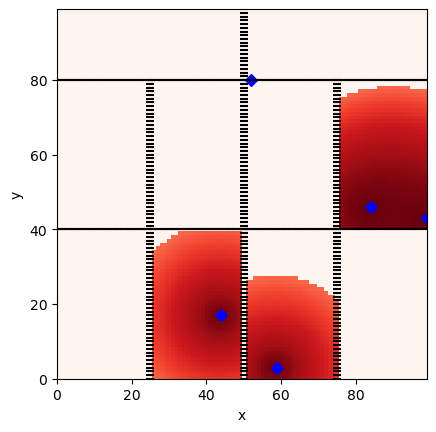

In [ ]:
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like


# this assumes a grid of size 100x100 
sol = np.zeros(100 * 100)

# add some cameras!
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1

actual_cameras = sum(sol)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")

# choose a layout


visualise_objective_function(sol, instance_size = instance_size, nb_cameras = actual_cameras, instance_file = myinst)
